<center style="font-weight:bold;font-size:26px">Pericolo - Marker Detection - Twenty euro</center>

# Setup

## Imports

In [1]:
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from skimage import feature, color, transform, io
from scipy.spatial import distance as dist
from PIL import Image, ImageDraw

In [3]:
sys.path.append(os.path.join(os.path.abspath(''), '.'))

## Global Variables

In [4]:
ROOT_FOLDER = os.path.join(os.path.abspath(''), '..')
DATA_FOLDER = os.path.join(ROOT_FOLDER, 'data')
IMG_FOLDER = os.path.join(DATA_FOLDER, 'img')
ANNOT_FOLDER = os.path.join(DATA_FOLDER, 'annotations')

# Functions definition

In [5]:
def read_img(filename, engine='cv'):
    if engine == 'cv':
        img = cv2.imread(filename)
    elif engine == 'skimage':
        img = io.imread(filename)
    return img

In [6]:
def get_img(df, idx, engine='cv'):
    print(df.loc[idx].file)
    return read_img(os.path.join(IMG_FOLDER, df.loc[idx].file), engine=engine)

## Plot functions

In [7]:
def imshow(img, figsize=(6, 6), cmap=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.show()

In [8]:
def imshow_masked(img, mask, figsize=(6,6), factor=0.3):
    fig = plt.figure(figsize=figsize)
    aux_img = img.astype(float)
    aux_mask = np.expand_dims(mask.astype(float)*(1-factor) + factor, axis=-1)
    drk_img = (aux_img * aux_mask).astype(np.uint8)
    plt.imshow(drk_img)
    plt.show()

## Mask generation

In [9]:
def polygon_to_mask(width, height, polygon):
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    return np.array(img)

## Detector functions

In [10]:
def drawer_detector(QueryImgBGR, trainImg, goodMatch, trainKP, queryKP, force_true = False):
    if (len(goodMatch)>=MIN_MATCH_COUNT) or force_true:
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,(0,255,0),5)
        print("Match Found")
        return trainBorder, queryBorder
    else:
        print("Not Enough match found-")
        print(len(goodMatch),MIN_MATCH_COUNT)
        return None

## Warp functions

In [11]:
def vector_representation(lines):
    locations = []
    directions = []
    strengths = []
    
    # For each detected line of 2 points
    for a,b in lines:
        a,b = np.array(a), np.array(b)
        locations.append((a + b) / 2) # generate the location as the middle point
        directions.append(b - a) # compute the direction vector
        strengths.append(np.linalg.norm(b - a)) # compute the strength as the norm
    
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)
    
    directions = np.array(directions) / np.linalg.norm(directions, axis=1)[:, np.newaxis] # normalize the directions
    
    return (locations, directions, strengths)

In [12]:
def to_homogenous_geometry(locations, directions, strengths):
    normals = np.zeros_like(directions) # Compute the edglets normal vector
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1) # Create the 3rd dimension representing the same point
    return lines

In [13]:
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [14]:
def infer_warp_shape(image, vp1, vp2, clip=False, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)
    
    max_x = int(max_x)
    max_y = int(max_y)
    
    return max_x, max_y

In [15]:
def warp_image(image, vp1, vp2, clip=True, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    # Create an Offset matrix
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    # Generate the final Homography matrix
    # by applying the offset on top of the previous matrices
    final_homography = np.dot(T, inter_matrix)

    # Generate the transformed image
    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img

# Main Code

## Initialisation

In [16]:
metadata_df = pd.read_csv(os.path.join(DATA_FOLDER, 'metadata.csv'), sep=';')
metadata_df.query('type == "TwentyEUR"').index

Int64Index([ 0,  2,  4, 10, 15, 17, 21, 23, 24, 25, 27, 28, 30, 31, 32, 36, 42,
            51, 55, 64, 65, 68, 70, 71, 72, 73, 77, 78],
           dtype='int64')

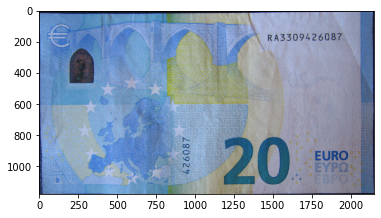

In [17]:
MARKER_NAME = "twenty_euro_sample4.png"
marker_img = io.imread(os.path.join(DATA_FOLDER, MARKER_NAME))
imshow(marker_img)

In [18]:
metadata_df.query('type == "TwentyEUR"').index

Int64Index([ 0,  2,  4, 10, 15, 17, 21, 23, 24, 25, 27, 28, 30, 31, 32, 36, 42,
            51, 55, 64, 65, 68, 70, 71, 72, 73, 77, 78],
           dtype='int64')

20191219_110513.jpg


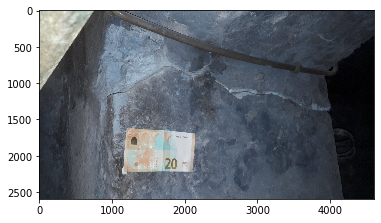

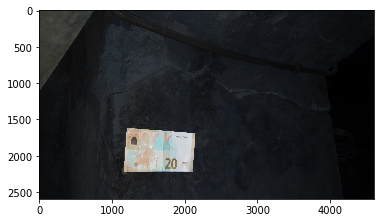

In [19]:
# Load Image # GE:  36,51 BE: 72, 71
IMG_INDEX = 36 # Select Image ID from metadata
raw_img = get_img(metadata_df, IMG_INDEX, engine='cv') # Open Image
raw_polygon = eval(metadata_df.loc[IMG_INDEX].polygon) # Load Ground Truth Polygon
raw_bndbox = eval(metadata_df.loc[IMG_INDEX].bnd_box) # Load Ground Truth Bounding Box
gt_mask = polygon_to_mask(raw_img.shape[1], raw_img.shape[0] , raw_polygon) # Generate Ground Truth Mask
imshow(raw_img)
imshow_masked(raw_img,gt_mask)

## Marker detection

### SIFT Detector

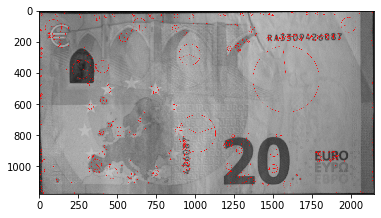

In [20]:
MIN_MATCH_COUNT=30
FLANN_INDEX_KDITREE=0
flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
flann=cv2.FlannBasedMatcher(flannParam,{})


sift_detector=cv2.xfeatures2d.SIFT_create()
sift_trainImg=cv2.imread(os.path.join(DATA_FOLDER, MARKER_NAME),0)
sift_trainKP,sift_trainDesc=sift_detector.detectAndCompute(sift_trainImg,None)
sift_trainImg1=cv2.drawKeypoints(sift_trainImg,sift_trainKP,None,(255,0,0),4)
plt.imshow(sift_trainImg1)
plt.show()

In [21]:
sift_QueryImgBGR = cv2.imread(os.path.join(IMG_FOLDER, metadata_df.loc[IMG_INDEX].file))
sift_QueryImg=cv2.cvtColor(sift_QueryImgBGR,cv2.COLOR_BGR2GRAY)
sift_queryKP,sift_queryDesc=sift_detector.detectAndCompute(sift_QueryImg,None)
sift_matches=flann.knnMatch(sift_queryDesc,sift_trainDesc,k=2)
sift_goodMatch=[]
for m,n in sift_matches:
    if(m.distance<0.75*n.distance):
        sift_goodMatch.append(m)
len(sift_goodMatch)

57

In [22]:
sift_borders = drawer_detector(
    QueryImgBGR=sift_QueryImgBGR,
    trainImg=sift_trainImg,
    goodMatch=sift_goodMatch,
    trainKP=sift_trainKP,
    queryKP=sift_queryKP,
    force_true=True
)

Match Found


In [23]:
if sift_borders is not None:
    sift_trainBorder, sift_queryBorder = sift_borders

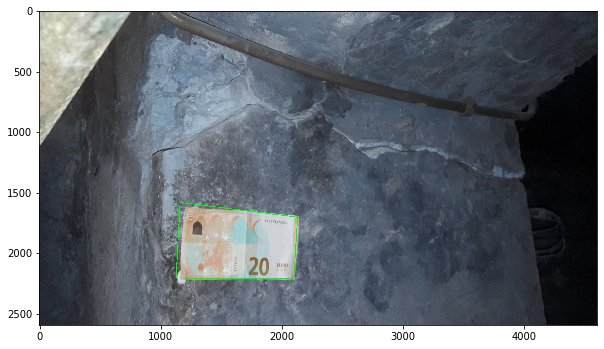

In [24]:
imshow(sift_QueryImgBGR, (10, 10))

GENERATED MASK


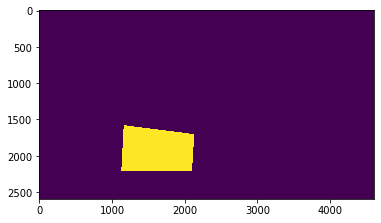

GROUND TRUTH MASK


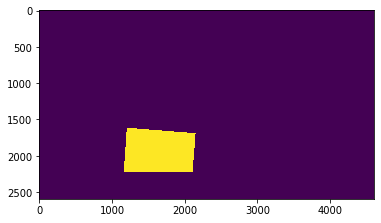

In [25]:
pred_mask = polygon_to_mask(sift_QueryImgBGR.shape[1], sift_QueryImgBGR.shape[0], sift_queryBorder)
print("GENERATED MASK")
imshow(pred_mask)
print("GROUND TRUTH MASK")
imshow(gt_mask)

In [26]:
I = pred_mask * gt_mask
U = (pred_mask + gt_mask).clip(max=1)
IoU = I.sum() / U.sum()
print(f"IoU = {IoU*100}%")

IoU = 90.61818701884002%


### SURF Detector

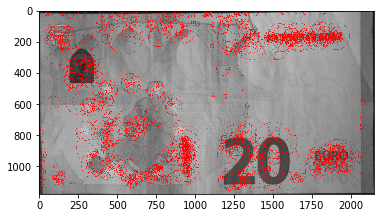

In [27]:
MIN_MATCH_COUNT=30
FLANN_INDEX_KDITREE=0
flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
flann=cv2.FlannBasedMatcher(flannParam,{})


surf_detector=cv2.xfeatures2d.SURF_create(300)
surf_trainImg=cv2.imread(os.path.join(DATA_FOLDER, MARKER_NAME),0)
surf_trainKP,surf_trainDesc=surf_detector.detectAndCompute(surf_trainImg,None)
surf_trainImg1=cv2.drawKeypoints(surf_trainImg,surf_trainKP,None,(255,0,0),4)
plt.imshow(surf_trainImg1)
plt.show()

In [28]:
surf_QueryImgBGR = cv2.imread(os.path.join(IMG_FOLDER, metadata_df.loc[IMG_INDEX].file))
surf_QueryImg=cv2.cvtColor(surf_QueryImgBGR,cv2.COLOR_BGR2GRAY)
surf_queryKP,surf_queryDesc=surf_detector.detectAndCompute(surf_QueryImg,None)
surf_matches=flann.knnMatch(surf_queryDesc,surf_trainDesc,k=2)
surf_goodMatch=[]
for e in surf_matches:
    if isinstance(e, list) and len(e) == 2:
        m, n = e
        if(m.distance<0.75*n.distance):
            surf_goodMatch.append(m)
len(surf_matches), len(surf_goodMatch)

(6469, 116)

In [29]:
surf_borders = drawer_detector(
    QueryImgBGR=surf_QueryImgBGR,
    trainImg=surf_trainImg,
    goodMatch=surf_goodMatch,
    trainKP=surf_trainKP,
    queryKP=surf_queryKP,
)
if surf_borders is not None:
    surf_trainBorder, surf_queryBorder = surf_borders

Match Found


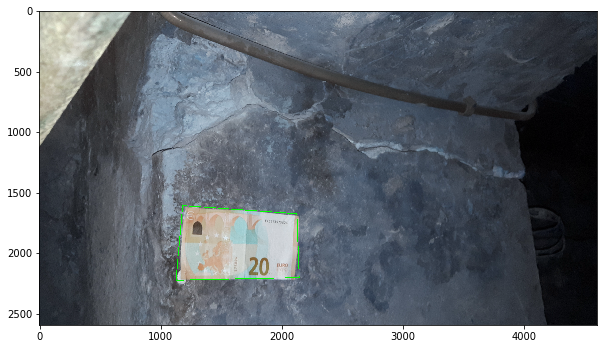

In [30]:
imshow(surf_QueryImgBGR, (10, 10))

GENERATED MASK


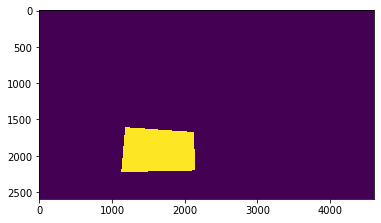

GROUND TRUTH MASK


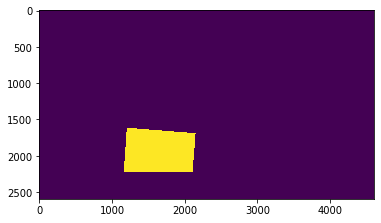

IoU = 92.5705149645652%


In [31]:
pred_mask = polygon_to_mask(surf_QueryImgBGR.shape[1], surf_QueryImgBGR.shape[0], surf_queryBorder)
print("GENERATED MASK")
imshow(pred_mask)
print("GROUND TRUTH MASK")
imshow(gt_mask)
I = pred_mask * gt_mask
U = (pred_mask + gt_mask).clip(max=1)
IoU = I.sum() / U.sum()
print(f"IoU = {IoU*100}%")

### Color Segmentation

A second lead to segment the bank note in the scene we can think of is **color segmentation**

First of all we try to establish the pixel profile of the bank note

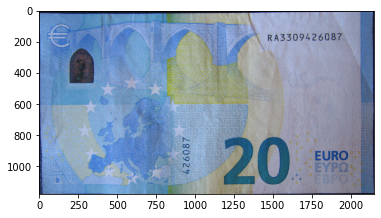

In [32]:
imshow(marker_img)

To procede to analysis we convert our RGB/BGR image to HSV Color Scale

See: [HSV & HLS Color model](https://en.wikipedia.org/wiki/HSL_and_HSV)

In [33]:
hsv_marker_img = cv2.cvtColor(marker_img[:,:,:3], cv2.COLOR_RGB2HSV)

HSV Range
> For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]

In [34]:
h, s, v = cv2.split(hsv_marker_img)

In [35]:
h.max(), s.max(), v.max()

(179, 234, 242)

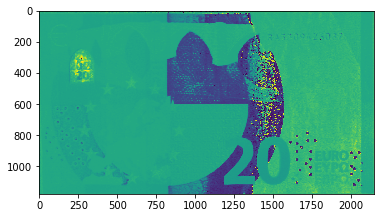

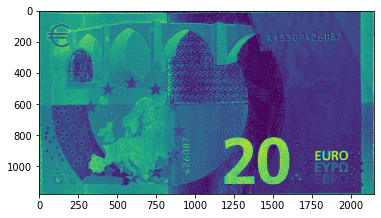

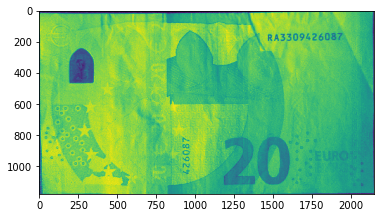

In [36]:
imshow(h)
imshow(s)
imshow(v)

Then we procede empirically by thresholding the Hue (which color to segment)

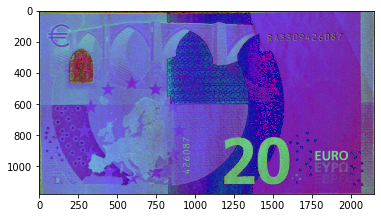

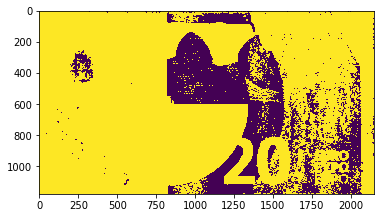

In [37]:
threshold_hsv = cv2.inRange(hsv_marker_img, (80, 0, 0), (120, 255, 255))
imshow(hsv_marker_img)
imshow(threshold_hsv)

As we can see, we can establish a good segmentation only by targetting the Hue value

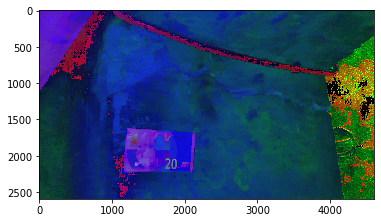

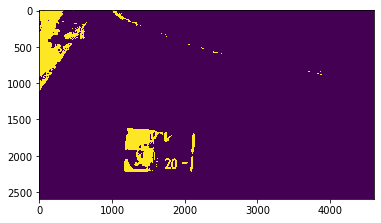

In [38]:
hsv_raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2HSV)
threshold_hsv = cv2.inRange(hsv_raw_img, (80, 20, 0), (120, 255, 255))
imshow(hsv_raw_img)
imshow(threshold_hsv)

But in the case of a real world scene, the complexity of luminosity, contrast, tint alteration and color blending make this task much harder and unreliable to scale

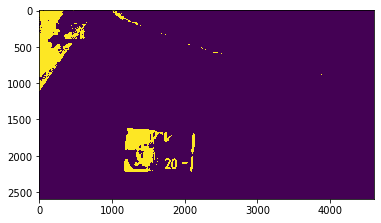

In [39]:
median = cv2.medianBlur(threshold_hsv, 5)
imshow(median)

In [42]:
import imutils
resized = imutils.resize(raw_img, width=300)
ratio = raw_img.shape[0] / float(resized.shape[0])
 
# blur the resized image slightly, then convert it to both
# grayscale and the L*a*b* color spaces
blurred = cv2.GaussianBlur(resized, (5, 5), 0)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]

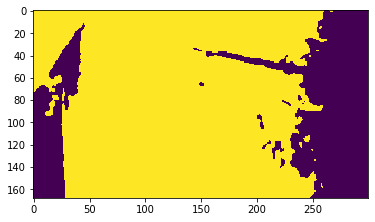

In [44]:
imshow(thresh)

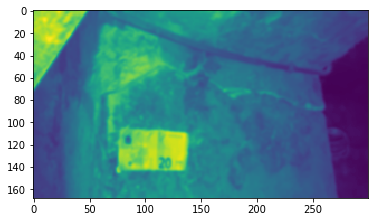

In [47]:
imshow(gray)

The sames goes for differential operators (Gaussian, Laplacian, Sobel...)

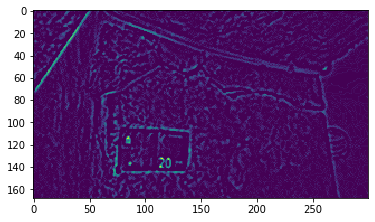

In [78]:
lap_img = cv2.Laplacian(gray, cv2.CV_8UC1)
imshow(lap_img)

In [74]:
resized_marker = imutils.resize(marker_img, width=300)
ratio_marker = marker_img.shape[0] / float(resized.shape[0])

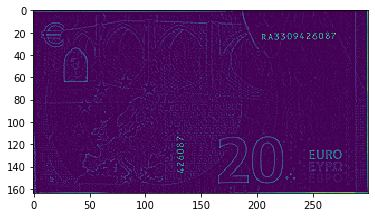

In [76]:
lap_marker = cv2.Laplacian(cv2.cvtColor(resized_marker, cv2.COLOR_RGB2GRAY), cv2.CV_8UC1)
imshow(lap_marker)

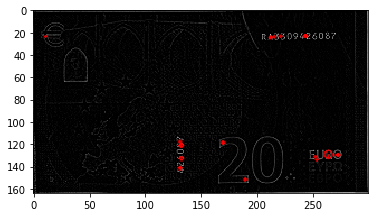

In [77]:
MIN_MATCH_COUNT=30
FLANN_INDEX_KDITREE=0
flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
flann=cv2.FlannBasedMatcher(flannParam,{})


sift_detector=cv2.xfeatures2d.SIFT_create()
sift_trainImg= lap_marker#cv2.imread(os.path.join(DATA_FOLDER, MARKER_NAME),0)
sift_trainKP,sift_trainDesc=sift_detector.detectAndCompute(sift_trainImg,None)
sift_trainImg1=cv2.drawKeypoints(sift_trainImg,sift_trainKP,None,(255,0,0),4)
plt.imshow(sift_trainImg1)
plt.show()

In [80]:
sift_QueryImgBGR = resized#cv2.imread(os.path.join(IMG_FOLDER, metadata_df.loc[IMG_INDEX].file))
sift_QueryImg=lap_img #cv2.cvtColor(sift_QueryImgBGR,cv2.COLOR_BGR2GRAY)
sift_queryKP,sift_queryDesc=sift_detector.detectAndCompute(sift_QueryImg,None)
sift_matches=flann.knnMatch(sift_queryDesc,sift_trainDesc,k=2)
sift_goodMatch=[]
for m,n in sift_matches:
    if(m.distance<0.75*n.distance):
        sift_goodMatch.append(m)
len(sift_goodMatch)

0